In [1]:
import sys
import os

# Add particle_detection to sys.path
sys.path.append(os.path.abspath(".."))

In [22]:
import torch
import numpy as np
from particle_detection.autoencoder.model import create_autoencoder
from particle_detection.autoencoder.utils import load_model
from particle_detection.data.dataset import ImageDataset, get_transforms

In [3]:
# Path to the trained model
model_path = "../saved_models/ae_1000_epochs.pth"

# Set the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create and load the model
model = create_autoencoder().to(device)
model = load_model(model, model_path, device=device)
model.eval()  # Set the model to evaluation mode

print("Model loaded successfully.")

[DEBUG] Loading model from: ../saved_models/ae_1000_epochs.pth
[DEBUG] Model loaded successfully from ../saved_models/ae_1000_epochs.pth.
Model loaded successfully.


In [4]:
from particle_detection.data.dataset import ImageDataset, get_transforms

# Define dataset and transformations
#dataset_dir = "/home/blah-buttery/nanoparticles/images/normal"  # gpu workstation image location
dataset_dir = "/Users/blah_m4/Desktop/nanoparticle/images" # macbook image location
transform = get_transforms(image_size=(1024, 1024), is_train=False)

# Create the dataset and dataloader
dataset = ImageDataset(data_dir=dataset_dir, transform=transform, split="test", test_size=0.2)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=False)

print(f"[DEBUG] Loaded dataset with {len(dataset)} samples for evaluation.")


[DEBUG] Loaded dataset with 3 samples for evaluation.


In [5]:
import torch.nn as nn

# Define loss function
criterion = nn.MSELoss()
# Evaluate the model
model.eval()  # Set the model to evaluation mode
total_loss = 0.0

with torch.no_grad():  # Disable gradient computation for evaluation
    for batch_idx, images in enumerate(dataloader):
        images = images.to(device)  # Move images to the same device as the model
        outputs = model(images)  # Forward pass through the model
        loss = criterion(outputs, images)  # Calculate reconstruction loss
        total_loss += loss.item()  # Accumulate the total loss

        print(f"[DEBUG] Batch {batch_idx + 1}/{len(dataloader)}, Loss: {loss.item():.4f}")

# Calculate average loss
average_loss = total_loss / len(dataloader)
print(f"Average Reconstruction Loss: {average_loss:.4f}")

[DEBUG] Batch 1/1, Loss: 0.0010
Average Reconstruction Loss: 0.0010


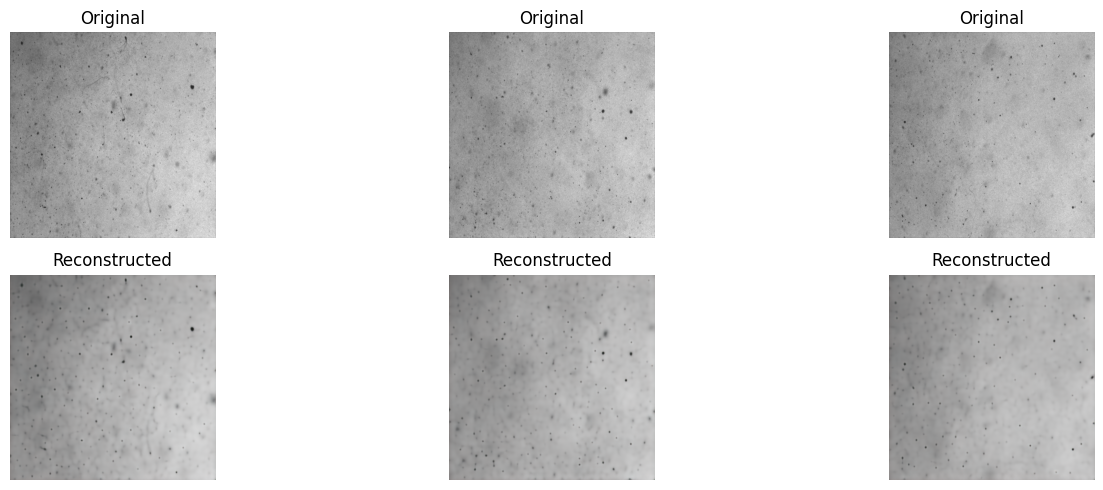

In [7]:
import matplotlib.pyplot as plt

# Get a batch of test images
images = next(iter(dataloader))  # Assuming your dataset returns images only
images = images.to(device)
outputs = model(images)

# Move to CPU for visualization
images = images.cpu().numpy()
outputs = outputs.cpu().detach().numpy()

# Plot original vs reconstructed images
fig, axes = plt.subplots(2, len(images), figsize=(15, 5))
for i in range(len(images)):
    # Original
    axes[0, i].imshow(images[i].transpose(1, 2, 0))  # Assuming images are CHW format
    axes[0, i].set_title("Original")
    axes[0, i].axis("off")
    # Reconstructed
    axes[1, i].imshow(outputs[i].transpose(1, 2, 0))
    axes[1, i].set_title("Reconstructed")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()


Shape of latent space: torch.Size([3, 512, 64, 64])
Shape of reshaped latent space: torch.Size([12288, 512])
Cluster labels grid shape: (3, 64, 64)


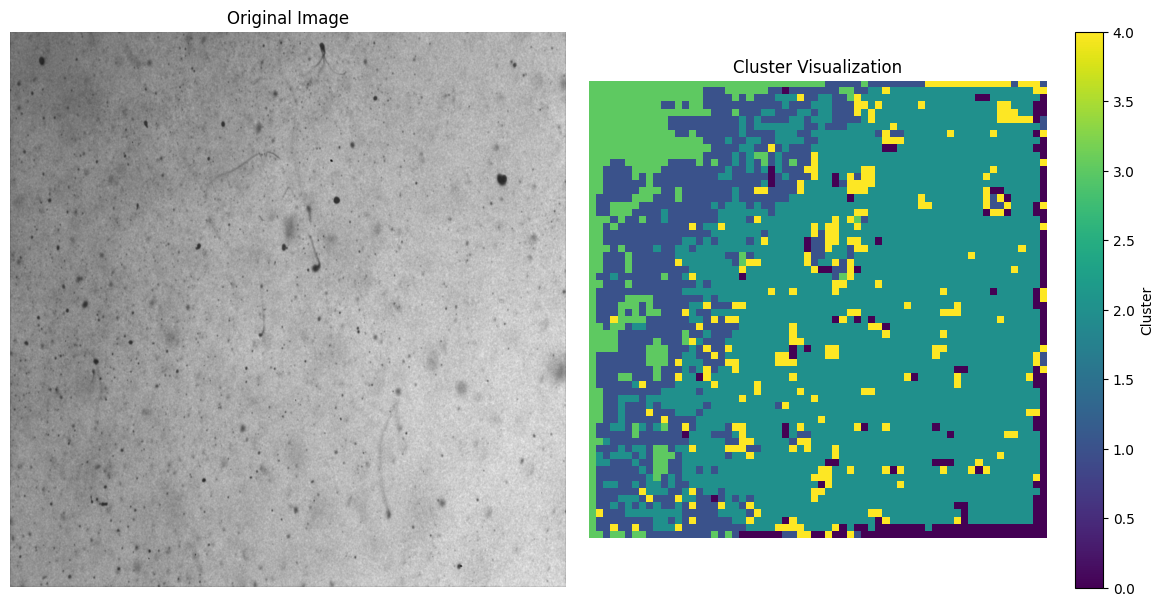

In [28]:
# Step 1: Update Patch Size
patch_size = 8  # Finer spatial granularity

# Step 2: Extract Latent Space Without Flattening Spatial Dimensions
model.eval()
with torch.no_grad():
    sample_img = next(iter(dataloader))
    sample_img = sample_img.to(device)
    latent_space = model.encoder(sample_img)  # Shape: [B, C, H, W]
    print(f"Shape of latent space: {latent_space.shape}")

# Step 3: Reshape for GMM Clustering
latent_space_reshaped = latent_space.permute(0, 2, 3, 1).reshape(-1, latent_space.shape[1])  # Shape: [N, C]
print(f"Shape of reshaped latent space: {latent_space_reshaped.shape}")

# Step 4: Apply GMM Clustering
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=5, random_state=42, covariance_type="full")
gmm.fit(latent_space_reshaped.cpu().numpy())  # Fit on reshaped latent space
cluster_labels = gmm.predict(latent_space_reshaped.cpu().numpy())  # Shape: [N]

# Step 5: Map Cluster Labels Back to Spatial Grid
grid_cols = latent_space.shape[3]  # 1024 / 8 = 128
grid_rows = latent_space.shape[2]  # 1024 / 8 = 128
cluster_labels_grid = cluster_labels.reshape(latent_space.shape[0], grid_rows, grid_cols)  # Shape: [B, H, W]

print(f"Cluster labels grid shape: {cluster_labels_grid.shape}")

# Step 6: Visualize the Clusters
def visualize_clusters_on_image(image_batch, cluster_labels_grid):
    """
    Visualize clusters directly on the spatial grid of the image.
    
    Args:
        image_batch (torch.Tensor): Batch of images, shape [B, C, H, W].
        cluster_labels_grid (np.ndarray): Cluster labels, shape [B, H, W].
    
    Returns:
        None
    """
    # Select the first image and its cluster labels
    single_image = image_batch[0]  # Shape: [C, H, W]
    single_cluster_labels = cluster_labels_grid[0]  # Shape: [H, W]

    # Visualize the image and clusters
    plt.figure(figsize=(12, 6))

    # Original Image
    plt.subplot(1, 2, 1)
    image_np = single_image.cpu().numpy().transpose(1, 2, 0)  # Convert CHW to HWC
    if image_np.max() > 1.0:
        image_np = image_np / 255.0  # Normalize
    plt.imshow(image_np, cmap="gray")
    plt.title("Original Image")
    plt.axis("off")

    # Cluster Overlay
    plt.subplot(1, 2, 2)
    plt.imshow(single_cluster_labels, cmap="viridis")
    plt.title("Cluster Visualization")
    plt.colorbar(label="Cluster")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Example usage:
visualize_clusters_on_image(sample_img, cluster_labels_grid)

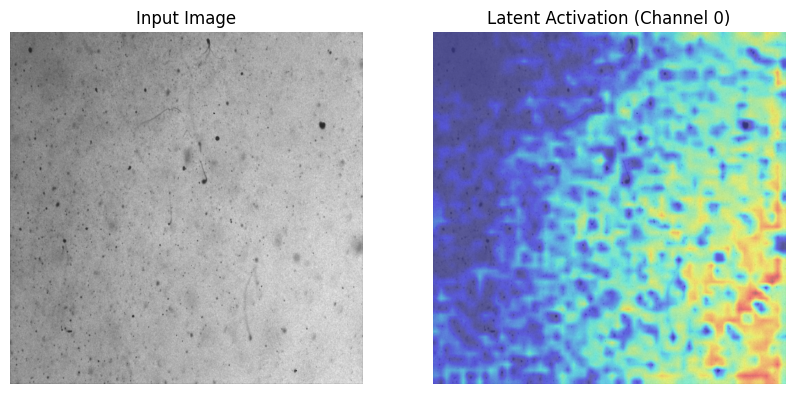

In [30]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import resize

def visualize_latent_with_input(model, dataloader, channel=0):
    model.eval()
    with torch.no_grad():
        # Get a sample image and its latent space
        sample_img = next(iter(dataloader))
        sample_img = sample_img.to(device)
        latent_space = model.encoder(sample_img)  # Get latent space

        # Select one channel and move it to CPU
        latent_activation = latent_space[0, channel, :, :].cpu()  # First image, specified channel

        # Normalize the activation for better visualization
        latent_activation -= latent_activation.min()
        latent_activation /= latent_activation.max()

        # Resize the activation to match the input size
        resized_activation = resize(latent_activation.unsqueeze(0), sample_img.shape[-2:])

        # Convert the input image to a CPU numpy array for visualization
        input_img = sample_img[0].cpu().permute(1, 2, 0).numpy()

        # Plot the input and overlay the activation
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(input_img)
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(input_img, alpha=0.7)
        plt.imshow(resized_activation.squeeze(), cmap="jet", alpha=0.5)
        plt.title(f"Latent Activation (Channel {channel})")
        plt.axis("off")
        plt.show()

# Visualize the latent space activation for a specific channel
visualize_latent_with_input(model, dataloader, channel=0)